In [1]:
# °°° Import datas from Binance °°°

import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import cufflinks as cf
import binance

client = binance.Client()
data = client.get_historical_klines('BTCBUSD', client.KLINE_INTERVAL_1DAY, '14-Dec-2017', '2-Feb-2023')
for i in range(0, len(data)):
    for j in range(0,11):
        data[i][j] = float(data[i][j])
for line in data:
    del line[2:4]
    del line[2:]

pd.options.display.max_rows = 999999
data = pd.DataFrame(data,columns = ['Date','Close'])
data['Date'] = pd.to_datetime(data['Date'], unit = 'ms',utc = True).map(lambda x:x.tz_convert('Europe/Rome'))
data.set_index('Date', inplace = True)

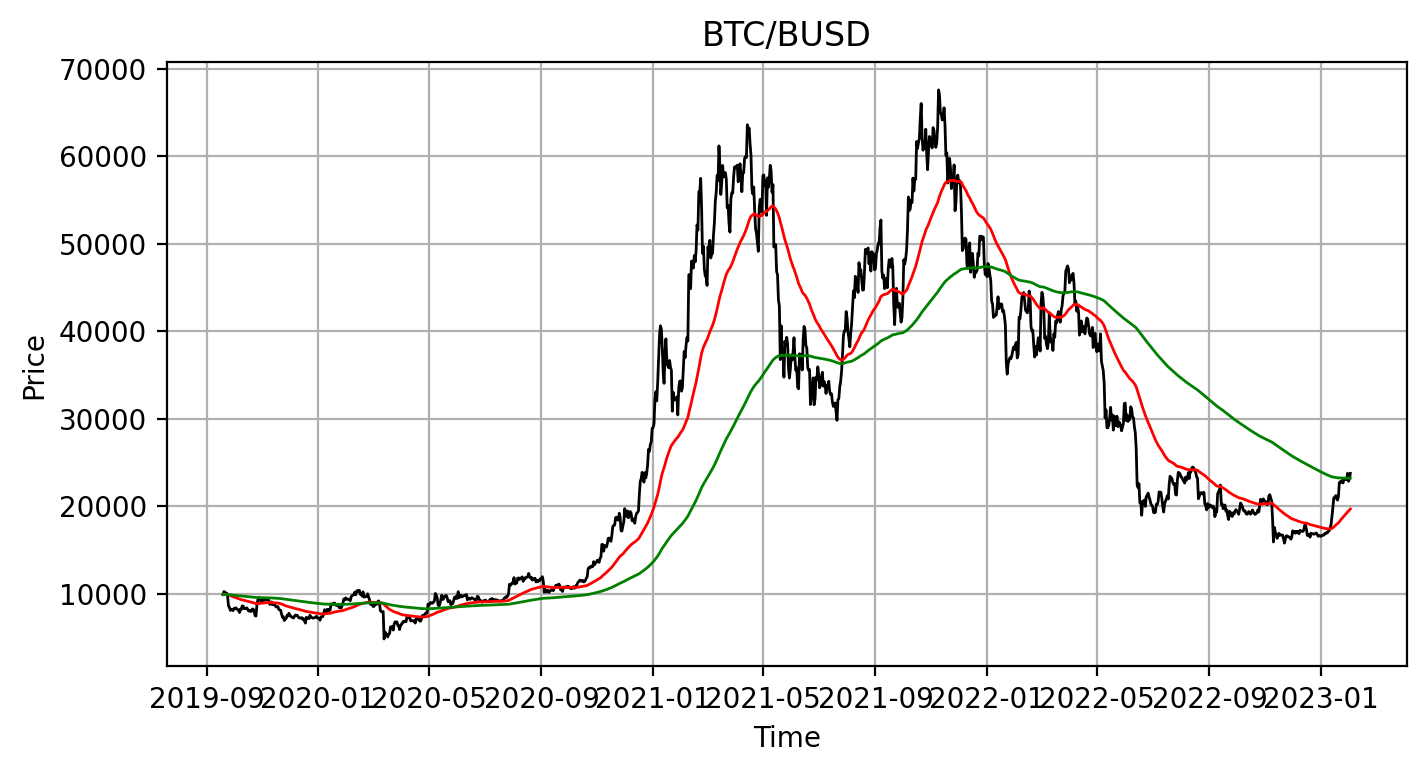

In [2]:
# This strategy uses two EMAs

data["EMA68"] = data.Close.ewm(span = 68, adjust = False).mean()
data["EMA274"] = data.Close.ewm(span = 274, adjust = False).mean()

plt.figure(figsize = (8,4), dpi = 200)
plt.plot(data.Close, color = 'black', linewidth = 1.0)
plt.plot(data.EMA68, color = 'red', linewidth = 1.0)
plt.plot(data.EMA274, color = 'green', linewidth = 1.0)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BTC/BUSD")
plt.grid(True)
plt.show();

In [3]:
data["DeltaPerc"]= data.Close.pct_change() # variazione percentuale tra la close n e la close n-1

data["Position"] = np.where((data.EMA68 > data.EMA274), 1, 0) # 1 quando la posizione è aperta / 0 quando è chiusa

data.Position = data.Position.shift(1) # shifto tutto di 1 altrimenti mi prevede il futuro

data["StrategyPerc"] = (data.DeltaPerc * data.Position) # Deltaperc quando Position = 1 / 0 altrimenti

data["Strategy_Equity"] = (data.StrategyPerc + 1).cumprod() * 100

data.dropna(inplace = True)

In [4]:
data.tail(10)

,Close,EMA68,EMA274,DeltaPerc,Position,StrategyPerc,Strategy_Equity
Date,,,,,,,
2023-01-24 01:00:00+01:00,22920.10,18602.458361,23201.112464,0.009094,0.0,0.0,266.087585
2023-01-25 01:00:00+01:00,22636.09,18719.375220,23197.003209,-0.012391,0.0,-0.0,266.087585
2023-01-26 01:00:00+01:00,23065.73,18845.356518,23196.048495,0.018980,0.0,0.0,266.087585
2023-01-27 01:00:00+01:00,23010.12,18966.074300,23194.696288,-0.002411,0.0,-0.0,266.087585
2023-01-28 01:00:00+01:00,23076.46,19085.215914,23193.836388,0.002883,0.0,0.0,266.087585
2023-01-29 01:00:00+01:00,23025.78,19199.435163,23192.614159,-0.002196,0.0,-0.0,266.087585
2023-01-30 01:00:00+01:00,23744.59,19331.178782,23196.628529,0.031218,0.0,0.0,266.087585
2023-01-31 01:00:00+01:00,22828.58,19432.552730,23193.951812,-0.038578,0.0,-0.0,266.087585
2023-02-01 01:00:00+01:00,23127.55,19539.654100,23193.468890,0.013096,0.0,0.0,266.087585


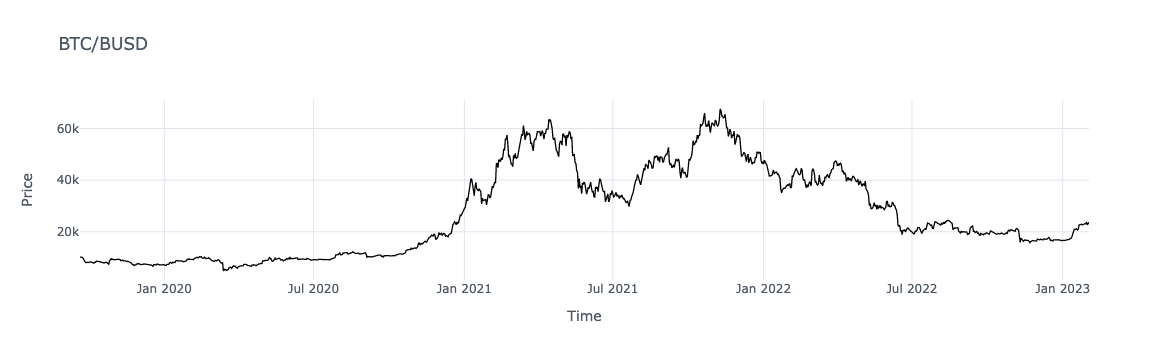

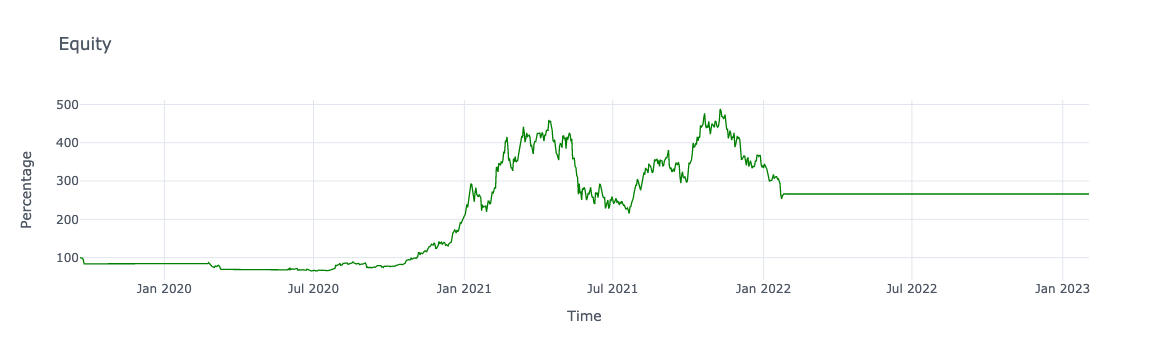

In [5]:
# Interactive EQUITY visualization

cf.go_offline() # will make cufflinks offline
cf.set_config_file(offline = False, world_readable = True)
data.Close.iplot(kind = "line", color = "black", theme = "white", title = "BTC/BUSD", xTitle = "Time", yTitle = "Price")
data.Strategy_Equity.iplot(kind = "line", color = "green", theme = "white", title = "Equity", xTitle = "Time", yTitle = "Percentage")